In [4]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from sklearn.mixture import GaussianMixture
import yfinance as yf

# TODO: how to fix this???
import sys
sys.path.append('/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/covariance_prediction_finance')

from cvx.covariance.trading_model import *
from cvx.covariance.utils import *
from cvx.covariance.predictors import *
from cvx.covariance.optimal_cov_pred import *
from cvx.covariance.ewma import *

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

# Import data

In [8]:
# Industry portfolios
data = pd.read_csv('../data/49_industries.csv', index_col=0, parse_dates=True)

# Risk-free rate and Fama-French factors
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [6]:
def cov_no_mean_correction(data, halflife):
    covariances = data.ewm(halflife=halflife).cov(bias=True)
    means = data.ewm(halflife=halflife).mean()

    # correct the covariance estimate by adding back the outer product of the current means
    for t, mean_vector in means.iterrows():
        yield t, covariances.loc[t].values + np.outer(mean_vector.values, mean_vector.values)

In [19]:
ewm1 = cov_no_mean_correction(data, halflife=20)

In [21]:
type(ewm1)

generator

In [22]:
for time, matrix in ewm1:
    pass
# ewm1 = pd.Series(ewm1)
# ewm1 = cov_no_mean_correction(data, halflife=20)

In [18]:
for time, matrix in ewma_cov(data, halflife=20):
    pass

In [75]:
import time
a = time.time()
ewm2 = pd.Series(ewma_cov(data, halflife=20))
b = time.time()
print(b-a)

0.5157780647277832


In [78]:
ewm1

0        (1969-07-01 00:00:00, [[2.9160000000000002e-05...
1        (1969-07-02 00:00:00, [[5.4618606804103314e-05...
2        (1969-07-03 00:00:00, [[3.677481437795041e-05,...
3        (1969-07-07 00:00:00, [[6.954007342340985e-05,...
4        (1969-07-08 00:00:00, [[6.544437356989757e-05,...
                               ...                        
13511    (2023-01-25 00:00:00, [[0.00019205980311954687...
13512    (2023-01-26 00:00:00, [[0.00018558430595463102...
13513    (2023-01-27 00:00:00, [[0.0001834596081130514,...
13514    (2023-01-30 00:00:00, [[0.00018836989964764303...
13515    (2023-01-31 00:00:00, [[0.00021200055296426886...
Length: 13516, dtype: object

In [52]:
ewm2

1969-07-01    [[2.9160000000000002e-05, 2.97e-05, -1.026e-05...
1969-07-02    [[5.461860680410333e-05, 7.208692717254607e-05...
1969-07-03    [[3.6774814377950394e-05, 4.317426273662217e-0...
1969-07-07    [[6.954007342340984e-05, 1.0090843904731896e-0...
1969-07-08    [[6.544437356989758e-05, 1.644293443693596e-05...
                                    ...                        
2023-01-25    [[0.00019205980311954706, 7.962934617232523e-0...
2023-01-26    [[0.0001855843059546312, 7.654967194219137e-05...
2023-01-27    [[0.0001834596081130516, 7.405554112092186e-05...
2023-01-30    [[0.00018836989964764322, 7.029983263396561e-0...
2023-01-31    [[0.00021200055296426902, 7.74150579492453e-05...
Length: 13516, dtype: object

In [48]:
pd.testing.assert_series_equal(ewm1, ewm2, rtol=1e-10, atol=1e-5)

KeyboardInterrupt: 

In [31]:
ewm1

<generator object cov_no_mean_correction at 0x7fa94508b4a0>

# Covariance predictors

In [6]:
# Rolling window predictor
rolling_window = RollingWindowPredictor(data, memory=500, update_freq=1)
rolling_window.name = "RW-500"

In [7]:
# EWMA predictor
ewma = EwmaPredictor(data, T_half=250)
ewma.name = "EWMA-250"

In [8]:
# Iterated EWMA predictor
iewma = IteratedEwmaPredictor(data, T_half_scale=125, T_half_full=250, init_cutoff=63, lamda=0)
iewma.name = "IEWMA-125-250"

In [9]:
# MGARCH predictor; precomputed in R due to computational complexity
# Note that the covariance matrices were computed for 100*r due to numerical issues 


mgarch_cond_cov_split = [];
n_chunks = 15
for i in range(n_chunks):
    mgarch_cond_cov_split.append(pd.read_csv("../mgarch_predictors from R/49_industries/mgarch_49_industries_{}.csv".format(i+1), index_col=0))
mgarch_cond_cov = pd.concat(mgarch_cond_cov_split)

Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, data.shape[1])

# Scale down the covariance matrices since they were computed for 100*r 
Sigmas = Sigmas/10000 

mgarch = CovariancePredictor()

# remove first year since it was used for training
mgarch.R = data.iloc[250:] 
mgarch.Sigma_hats = {mgarch.R.index[t]: Sigmas[t] for t in range(Sigmas.shape[0])}
mgarch.n = mgarch.R.shape[1]
mgarch.T = mgarch.R.shape[0]

mgarch.name = "MGARCH"

assert list(mgarch.R.index) == [*mgarch.Sigma_hats.keys()]

FileNotFoundError: [Errno 2] No such file or directory: '../mgarch predictors from R/49 industries/mgarch_49_industries_1.csv'

In [ ]:
# Weighted iterated EWMA predictor
T_halfs = [(21, 63), (63, 125), (125, 250), (250, 500), (500, 1000)]
const_L = "off"
turnover_cons = None
ignore_dpp = True
cm_iewma = AlternatingWeightedPredictor("iterated_ewma", data, T_halfs, likelihood_memory=10, init_cutoff=63, const_L=const_L,\
     ignore_dpp=ignore_dpp, turnover_cons=turnover_cons,\
       lamdas=[0.05, 0, 0, 0, 0])
cm_iewma.name = "CM-IEWMA"

Solving convex problem for time-varying L...


100%|██████████| 13441/13441 [06:09<00:00, 36.36it/s]


Finishing...


In [10]:
# Prescient predictor

Sigma_hats = {}
for t in data.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    Sigma_hats[t] = np.cov(data.loc[(data.index.year == t.year) & (data.index.quarter == quarter)].values, rowvar=False)

prescient = CovariancePredictor()
prescient.R = data
prescient.Sigma_hats = Sigma_hats
prescient.n = prescient.R.shape[1]
prescient.T = prescient.R.shape[0]
prescient.name = "PRESCIENT"

assert list(prescient.R.index) == [*prescient.Sigma_hats.keys()]

# Define end and start dates for backtests

In [11]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("1971-06-24", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

# CM-IEWMA component weights

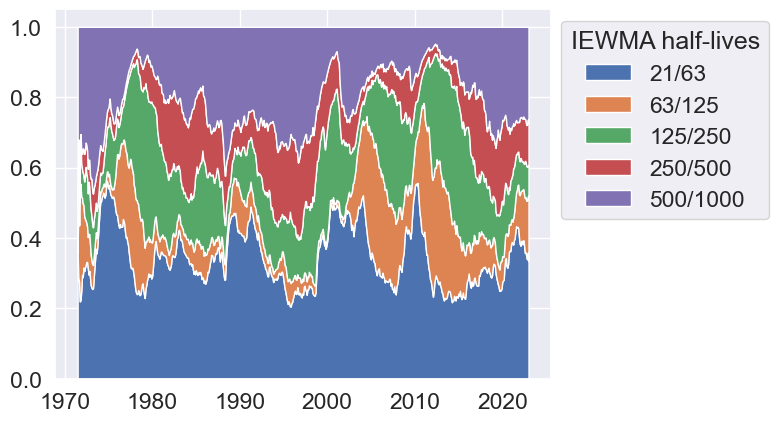

In [11]:
# plot component weights (monthly averages)
weights = cm_iewma.weights.loc[start_date:end_date].resample("M").mean().values
dates=cm_iewma.weights.loc[start_date:end_date].resample("M").mean().index
plt.stackplot(dates, get_ewmas(weights[-cm_iewma.T:], 10).T); 
plt.legend(title="IEWMA half-lives", bbox_to_anchor=(1.23, 1), loc='upper center', ncol=1, labels=[f"{T[0]}/{T[1]}"for T in T_halfs]);

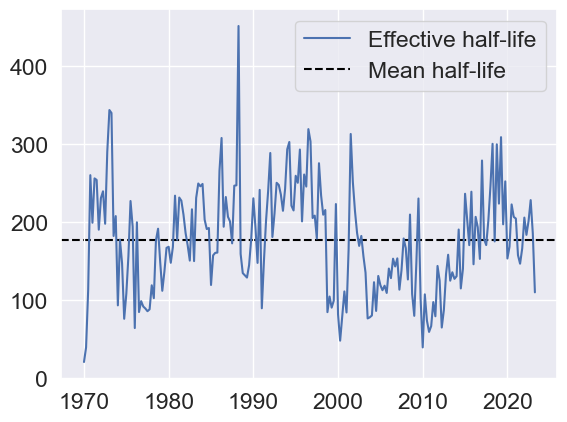

In [12]:
# plot effective half-life (quarterly averages)
T1s = np.array([T_halfs[i][0] for i in range(len(T_halfs))]).reshape(-1,1)
T2s = np.array([T_halfs[i][1] for i in range(len(T_halfs))]).reshape(-1,1)


effective_T1 = pd.DataFrame((cm_iewma.weights.values * T1s.T).sum(axis=1),\
    index=cm_iewma.weights.index, columns=["T1"])
effective_T2 = pd.DataFrame((cm_iewma.weights.values * T2s.T).sum(axis=1),\
    index=cm_iewma.weights.index, columns=["T2"])


plt.plot(effective_T1.resample("Q").mean(), label="Effective half-life");
plt.axhline(float(effective_T1.mean()), color="black", linestyle="--", label="Mean half-life", zorder=-1);
plt.legend();

# Define list of predictors and create Cholesky factors

In [12]:
# List of predictors
predictors = [rolling_window, ewma, iewma, mgarch, cm_iewma, prescient]
labels = [predictor.name for predictor in predictors]

# Get log-likelihoods and Lt_hats (Lt_hats used for some optimization problems)
for predictor in predictors:
    predictor.get_Lt_hats(start_date, end_date)
    predictor.get_log_likelihoods(start_date, end_date)

# Log-likelihood plot (quarterly averages)

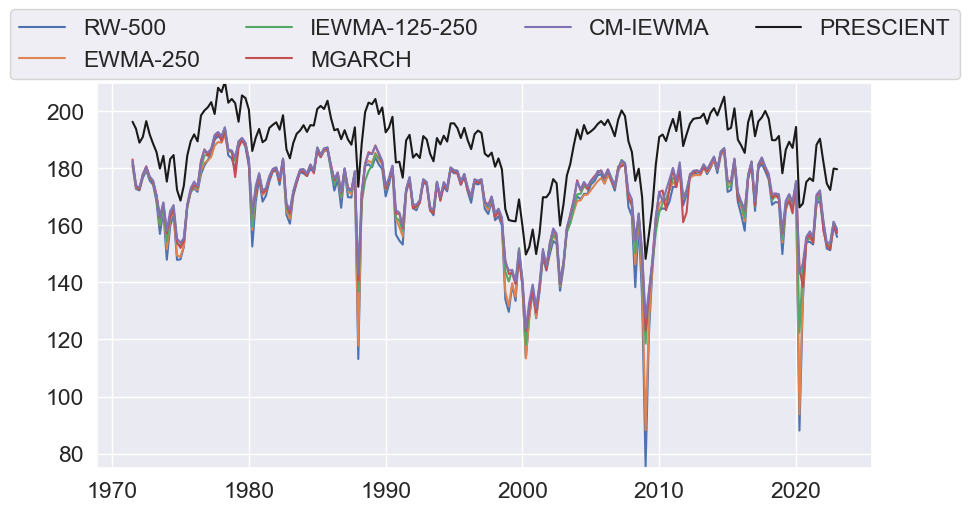

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
prescient_ind = len(predictors)-1
for i, predictor in enumerate(predictors):
    if i==prescient_ind:
        plt.plot(predictor.log_likelihoods.resample("Q").mean().index, \
        predictor.log_likelihoods.resample("Q").mean(), c="k")
    else:
        plt.plot(predictor.log_likelihoods.resample("Q").mean().index, \
        predictor.log_likelihoods.resample("Q").mean())

plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=labels, scatterpoints=1, markerscale=5);
plt.ylim(75,210);

# Regret plot (quarterly averages)

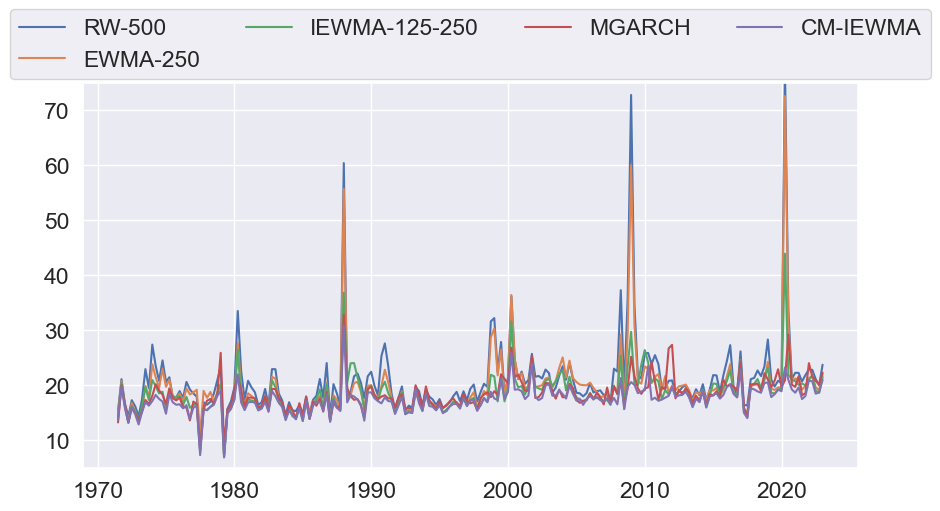

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
all_regrets = []
for i, predictor in enumerate(predictors[:-1]):
    regret =  prescient.\
        log_likelihoods.resample("Q").mean() \
            - predictor.log_likelihoods.resample("Q").mean()
            
    plt.plot(predictor.log_likelihoods.resample("Q").mean().index, regret)
    all_regrets.append(regret.values.flatten())

plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=labels, scatterpoints=1, markerscale=5);
plt.ylim(5,75);


### Compare CM-IEWMA with MGARCH

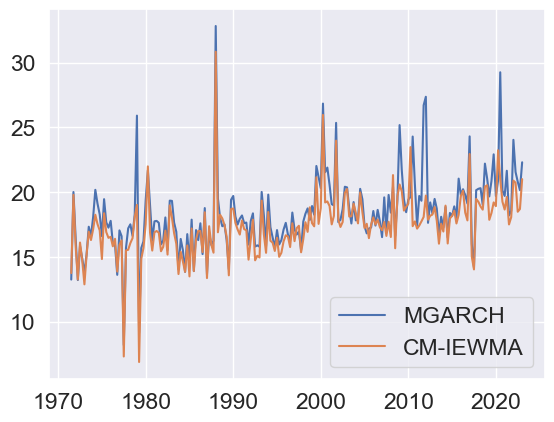

In [16]:
# Regret or W-IT-EWMA and MGARCH
regret_mgarch =  prescient.\
        log_likelihoods.resample("Q").mean() \
            - mgarch.log_likelihoods.resample("Q").mean()

plt.plot(mgarch.log_likelihoods.resample("Q").mean().index, regret_mgarch, label=mgarch.name)

regret_cm_iewma =  prescient.\
        log_likelihoods.resample("Q").mean() \
            - cm_iewma.log_likelihoods.resample("Q").mean()

plt.plot(predictor.log_likelihoods.resample("Q").mean().index, regret_cm_iewma, label=cm_iewma.name)
plt.legend();

In [17]:
cm_iewma_advantage = ((regret_cm_iewma.values - regret_mgarch.values)<0).mean()
print(f"CM-IEWMA is better than MGARCH {cm_iewma_advantage:.0%} of the time")

CM-IEWMA is better than MGARCH 85% of the time


### Regret CDF plots

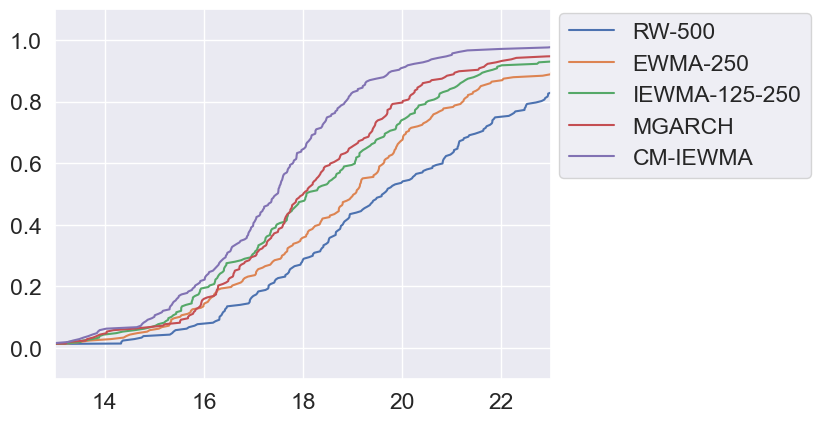

In [18]:
plot_ecdf(all_regrets, labels=labels[:-1])
plt.xlim(13,23)
plt.ylim(-0.1,1.1)
# put label to right of plot
plt.legend(bbox_to_anchor=(1.27, 1.02), loc='upper center', ncol=1, labels=labels[:-1]);

### Regret metrics

In [19]:
### Metrics
print("(Mean, Std, Max, 99th percentile, 95th percentile, 90th percentile)")

for i, predictor in enumerate(predictors):
    print("\n", labels[i])

    # regret =  predictors[last].log_likelihoods.resample("Q").mean() -\
    #     predictor.log_likelihoods.resample("Q").mean()
    # regret = regret.values
    
    if i < prescient_ind:
        regret = all_regrets[i]
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1), np.quantile(regret, 0.99).round(1),\
            np.quantile(regret, 0.95).round(1), np.quantile(regret, 0.9).round(1))

        print(metrics)
    else:
        print((0.0, 0.0, 0.0, 0.0, 0.0, 0.0))

(Mean, Std, Max, 99th percentile, 95th percentile, 90th percentile)

 RW-500
(21.0, 7.4, 78.3, 59.0, 30.6, 25.4)

 EWMA-250
(19.8, 6.3, 72.6, 54.5, 27.3, 23.3)

 IEWMA-125-250
(18.6, 3.7, 43.9, 31.5, 24.0, 21.8)

 MGARCH
(18.4, 2.9, 32.8, 27.3, 23.7, 21.3)

 CM-IEWMA
(17.4, 2.4, 30.8, 23.9, 21.0, 19.8)

 PRESCIENT
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


# Portfolio optimization

In [13]:
# Risk-free rate for backtest period; for cash allocation
rf = rf_rate.loc[start_date:end_date]

# Portfolio constraints
additonal_cons={"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}

### Equally weighted

In [21]:
from cvx.covariance.trading_model import *
adjust_factor = 1

traders_eq_w = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
    trader.ws = np.ones(trader.R.shape) / trader.n
    trader.portfolio_type = "eq_weighted"
    trader.adjust_factor = adjust_factor
    traders_eq_w.append(trader)

100%|██████████| 6/6 [00:04<00:00,  1.22it/s]


In [22]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_eq_w):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=0.05, rf=rf,\
        excess=excess)


RW-500
Mean annual return: 2.23%
Annual risk: 5.38%
Sharpe ratio: 0.415
Maximum drawdown: 16.42%

EWMA-250
Mean annual return: 2.19%
Annual risk: 5.10%
Sharpe ratio: 0.43
Maximum drawdown: 14.97%

IEWMA-125-250
Mean annual return: 2.24%
Annual risk: 5.11%
Sharpe ratio: 0.438
Maximum drawdown: 15.00%

MGARCH
Mean annual return: 2.44%
Annual risk: 5.08%
Sharpe ratio: 0.482
Maximum drawdown: 14.01%

CM-IEWMA
Mean annual return: 2.30%
Annual risk: 4.98%
Sharpe ratio: 0.463
Maximum drawdown: 12.94%

PRESCIENT
Mean annual return: 4.44%
Annual risk: 5.01%
Sharpe ratio: 0.886
Maximum drawdown: 8.58%


### Minimum risk

In [14]:
from cvx.covariance.trading_model import *

adjust_factor = 1

C_speedup = False # True if solving using CVXPYgen
traders_min_risk = []

for i in trange(len(predictors)):
     predictor = predictors[i]
     R = predictor.R.loc[start_date:end_date]
     Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
     Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}

     trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
     trader.backtest(adjust_factor=adjust_factor, additonal_cons=additonal_cons,\
          C_speedup=C_speedup)
     traders_min_risk.append(trader)


  0%|          | 0/6 [00:00<?, ?it/s]

Adding additional constraints


 17%|█▋        | 1/6 [02:03<10:17, 123.40s/it]

Adding additional constraints


 33%|███▎      | 2/6 [04:40<09:32, 143.10s/it]

Adding additional constraints


 50%|█████     | 3/6 [07:39<07:58, 159.65s/it]

Adding additional constraints


 67%|██████▋   | 4/6 [11:04<05:54, 177.37s/it]

Adding additional constraints


 83%|████████▎ | 5/6 [15:38<03:32, 212.43s/it]

Adding additional constraints


100%|██████████| 6/6 [18:38<00:00, 186.36s/it]


In [1]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_min_risk):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=0.05, rf=rf,\
        excess=excess)

NameError: name 'traders_min_risk' is not defined

### Maximum diversification 

In [27]:
from cvx.covariance.trading_model import *

# Only additonal_cons["upper_bound"] relevant for max diverse

adjust_factor = 1

traders_max_diverse = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
    trader.backtest(adjust_factor=adjust_factor, additonal_cons=additonal_cons,\
         portfolio_type="max_diverse")
    traders_max_diverse.append(trader)

100%|██████████| 6/6 [17:39<00:00, 176.65s/it]


In [29]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_max_diverse):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=0.05, rf=rf,\
        excess=excess)


RW-500
Mean annual return: 2.09%
Annual risk: 5.53%
Sharpe ratio: 0.378
Maximum drawdown: 16.12%

EWMA-250
Mean annual return: 2.11%
Annual risk: 5.15%
Sharpe ratio: 0.409
Maximum drawdown: 15.62%

IEWMA-125-250
Mean annual return: 2.20%
Annual risk: 5.16%
Sharpe ratio: 0.426
Maximum drawdown: 13.81%

MGARCH
Mean annual return: 2.51%
Annual risk: 5.07%
Sharpe ratio: 0.495
Maximum drawdown: 12.11%

CM-IEWMA
Mean annual return: 2.29%
Annual risk: 5.03%
Sharpe ratio: 0.455
Maximum drawdown: 12.15%

PRESCIENT
Mean annual return: 4.82%
Annual risk: 5.04%
Sharpe ratio: 0.958
Maximum drawdown: 11.35%


### Risk parity 

In [30]:
from cvx.covariance.trading_model import *
adjust_factor = 1
    
traders_risk_par = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
    trader.backtest(adjust_factor=adjust_factor, portfolio_type="risk_parity")
    traders_risk_par.append(trader)

100%|██████████| 6/6 [24:32<00:00, 245.34s/it]


In [31]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_risk_par):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=0.05, rf=rf,\
        excess=excess)


RW-500
Mean annual return: 2.44%
Annual risk: 5.45%
Sharpe ratio: 0.448
Maximum drawdown: 16.01%

EWMA-250
Mean annual return: 2.38%
Annual risk: 5.12%
Sharpe ratio: 0.465
Maximum drawdown: 15.44%

IEWMA-125-250
Mean annual return: 2.46%
Annual risk: 5.13%
Sharpe ratio: 0.479
Maximum drawdown: 14.37%

MGARCH
Mean annual return: 2.66%
Annual risk: 5.12%
Sharpe ratio: 0.519
Maximum drawdown: 14.26%

CM-IEWMA
Mean annual return: 2.52%
Annual risk: 4.98%
Sharpe ratio: 0.505
Maximum drawdown: 12.65%

PRESCIENT
Mean annual return: 5.16%
Annual risk: 5.02%
Sharpe ratio: 1.03
Maximum drawdown: 8.97%


### Maximum Sharp ratio

In [37]:
from cvx.covariance.trading_model import *
    
# EWMA returns
r_ewma = get_ewmas(data.values, T_half=63)
r_hat_ewma = pd.DataFrame(r_ewma[:-1], index=data.index[1:],\
     columns=data.columns)
r_hat_ewma = r_hat_ewma.loc[start_date:end_date]  

# previous day's returns
# r_hats = pd.DataFrame(data.iloc[:-1].values, index=data.index[1:],\
#      columns=data.columns)
# r_hats = r_hats.loc[start_date:end_date]

traders_max_sharpe = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats,\
    r_hats=r_hat_ewma)
    trader.backtest(adjust_factor=adjust_factor, additonal_cons=additonal_cons,\
        portfolio_type="mean_variance", sigma_des=0.05)
    traders_max_sharpe.append(trader)

  0%|          | 0/6 [00:00<?, ?it/s]/Users/kasper/opt/anaconda3/envs/cov_pred/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:209: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(
100%|██████████| 6/6 [40:06<00:00, 401.16s/it]


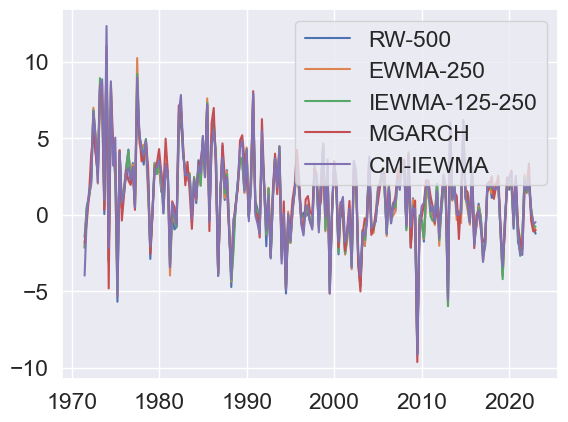

In [67]:
for i, trader in enumerate(traders_max_sharpe[:-1]):
    rets = trader.rets - rf.values
    rets = pd.DataFrame(rets,index=trader.R.index)
    mu = rets.resample("Q").mean()
    sigma = rets.resample("Q").std()
    SR = (mu / sigma) * np.sqrt(252)
    # plt.plot(SR);

    plt.plot(SR, label=labels[i])
plt.legend();

In [40]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_max_sharpe):
    print("\n"+labels[i])
    trader.get_metrics(diluted_with_cash=False, rf=rf,\
        excess=excess)


RW-500
Mean annual return: 7.26%
Annual risk: 7.34%
Sharpe ratio: 0.989
Maximum drawdown: 26.62%

EWMA-250
Mean annual return: 6.79%
Annual risk: 6.71%
Sharpe ratio: 1.01
Maximum drawdown: 22.85%

IEWMA-125-250
Mean annual return: 7.33%
Annual risk: 6.52%
Sharpe ratio: 1.12
Maximum drawdown: 19.64%

MGARCH
Mean annual return: 8.63%
Annual risk: 6.57%
Sharpe ratio: 1.31
Maximum drawdown: 17.69%

CM-IEWMA
Mean annual return: 7.42%
Annual risk: 6.18%
Sharpe ratio: 1.2
Maximum drawdown: 16.19%

PRESCIENT
Mean annual return: 12.78%
Annual risk: 5.10%
Sharpe ratio: 2.51
Maximum drawdown: 10.46%


In [36]:
# Portfolio metrics
excess=False
for i, trader in enumerate(traders_max_sharpe):
    print("\n"+labels[i])
    trader.get_metrics(diluted_with_cash=False, rf=rf,\
        excess=excess)


RW-500
Mean annual return: 14.06%
Annual risk: 7.26%
Sharpe ratio: 1.94
Maximum drawdown: 44.57%

EWMA-250
Mean annual return: 12.76%
Annual risk: 6.67%
Sharpe ratio: 1.91
Maximum drawdown: 46.34%

IEWMA-125-250
Mean annual return: 13.56%
Annual risk: 6.46%
Sharpe ratio: 2.1
Maximum drawdown: 37.00%

MGARCH
Mean annual return: 15.91%
Annual risk: 6.14%
Sharpe ratio: 2.59
Maximum drawdown: 30.58%

CM-IEWMA
Mean annual return: 13.50%
Annual risk: 6.03%
Sharpe ratio: 2.24
Maximum drawdown: 31.27%

PRESCIENT
Mean annual return: 18.33%
Annual risk: 4.55%
Sharpe ratio: 4.03
Maximum drawdown: 9.34%
